
### 코드 설명

1. **CIFAR-100 사전학습:**  
   CIFAR-100 데이터셋을 사용해 `SimpleCNN` 모델을 5 에폭 동안 학습한 후, 가중치를 저장합니다.

2. **MNIST 데이터 전처리:**  
   MNIST 이미지를 32×32, 3채널로 변환하여 CIFAR-100 모델에 맞게 전처리합니다.

3. **MNIST Full Fine-tuning:**  
   - CIFAR-100 사전학습된 feature extractor를 불러온 후, classifier의 마지막 레이어를 `Linear(256, 10)`으로 교체합니다.  
   - 전체 네트워크를 업데이트하며 (전체 파라미터 학습), 작은 학습률(1e-4)을 사용합니다.  
   - 에폭별 train/validation loss와 accuracy를 각각 `ft_train_losses`, `ft_train_accs`, `ft_val_losses`, `ft_val_accs`에 저장합니다.

4. **MNIST Feature Extraction:**  
   - 동일하게 사전학습된 feature extractor를 로드한 후, feature extractor는 고정시키고 classifier만 재정의하여 업데이트합니다.  
   - classifier만 업데이트합니다. 학습률은 1e-3을 사용합니다.  
   - 에폭별 metric은 `fe_train_losses`, `fe_train_accs`, `fe_val_losses`, `fe_val_accs`에 저장합니다.

5. **성능 비교 Plot:**  
   - 두 실험의 Accuracy와 Loss를 각각 plot하여 비교합니다.

이 코드를 실행하면 두 접근법의 에폭별 성능 변화를 비교할 수 있는 plot이 생성됩니다.

In [ ]:

import math

import torchvision
import torchvision.transforms as transforms


# 이미지 시각화를 위한 함수 (단일 이미지 표시용)
def imshow(img, title=None, cmap=None):
    npimg = img.numpy() # tensor -> numpy, memory sharing
    if npimg.shape[0] == 1:  # 흑백 이미지의 경우
        npimg = npimg[0]
    else:
        npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')

def print_dataset_info(name, train_set, test_set):
    sample_img, sample_label = train_set[0]
    print(f"========== {name} ==========")
    print("Train 샘플 개수:", len(train_set))
    print("Test 샘플 개수:", len(test_set))
    print("샘플 이미지 텐서 shape:", sample_img.shape)  # (채널, 높이, 너비)
    if hasattr(train_set, 'classes'):
        print("클래스 (카테고리) 개수:", len(train_set.classes))
        print("클래스 이름:", train_set.classes)
    print()

def visualize_one_per_category(dataset, dataset_name="Dataset", cmap=None):
    """
    각 카테고리에서 1개의 샘플 이미지를 수집하여 한 화면에 grid로 시각화합니다.
    - dataset: torchvision 데이터셋 (transform이 적용된 상태)
    - dataset_name: 데이터셋 이름 (출력 제목에 사용)
    - cmap: 흑백일 경우 'gray' 지정
    """
    samples = {}  # key: label, value: 이미지 텐서

    # dataset.targets (또는 train_labels)를 통해 클래스 정보를 확인
    targets = dataset.targets if hasattr(dataset, 'targets') else dataset.train_labels

    # sample에 이미지 추가
    for idx in range(len(dataset)):
        img, label = dataset[idx]
        # label이 tensor인 경우 정수형으로 변환
        if torch.is_tensor(label):
            label = label.item()
        if label not in samples:
            samples[label] = img
        if len(samples) >= len(dataset.classes):
            break

    n_categories = len(dataset.classes)
    print(f"{dataset_name} 카테고리 개수: {n_categories}")

    # Grid 배치를 위해 (예: 10열로 배치)
    cols = 10 if n_categories >= 10 else n_categories
    rows = math.ceil(n_categories / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    # axes가 2차원 배열인 경우 flatten하여 사용
    if rows * cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # 클래스 id 오름차순으로 정렬하여 시각화
    for i, label in enumerate(sorted(samples.keys())):
        ax = axes[i]
        img = samples[label]
        npimg = img.numpy()
        if npimg.shape[0] == 1:  # 흑백 이미지
            npimg = npimg[0]
            ax.imshow(npimg, cmap=cmap)
        else:
            npimg = np.transpose(npimg, (1, 2, 0))
            ax.imshow(npimg)
        class_name = dataset.classes[label] if hasattr(dataset, 'classes') else str(label)
        ax.set_title(class_name, fontsize=8)
        ax.axis('off')

    # 남은 subplot 축 숨기기 (있을 경우)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"{dataset_name} - 1 sample per category", fontsize=14)
    plt.tight_layout()
    plt.show()

# --------------------------------------------------
# 데이터셋 준비
# --------------------------------------------------
# CIFAR-100 데이터셋 (3채널 컬러 이미지, 32x32)
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # 옵션: 정규화
])
cifar_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_cifar)
cifar_test  = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_cifar)

# MNIST 데이터셋 (1채널 흑백 이미지, 28x28)
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))  # 옵션: 정규화
])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)


100%|██████████| 169M/169M [00:03<00:00, 50.0MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 50.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.60MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.71MB/s]


========== CIFAR100 ==========
Train 샘플 개수: 50000
Test 샘플 개수: 10000
샘플 이미지 텐서 shape: torch.Size([3, 32, 32])
클래스 (카테고리) 개수: 100
클래스 이름: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 

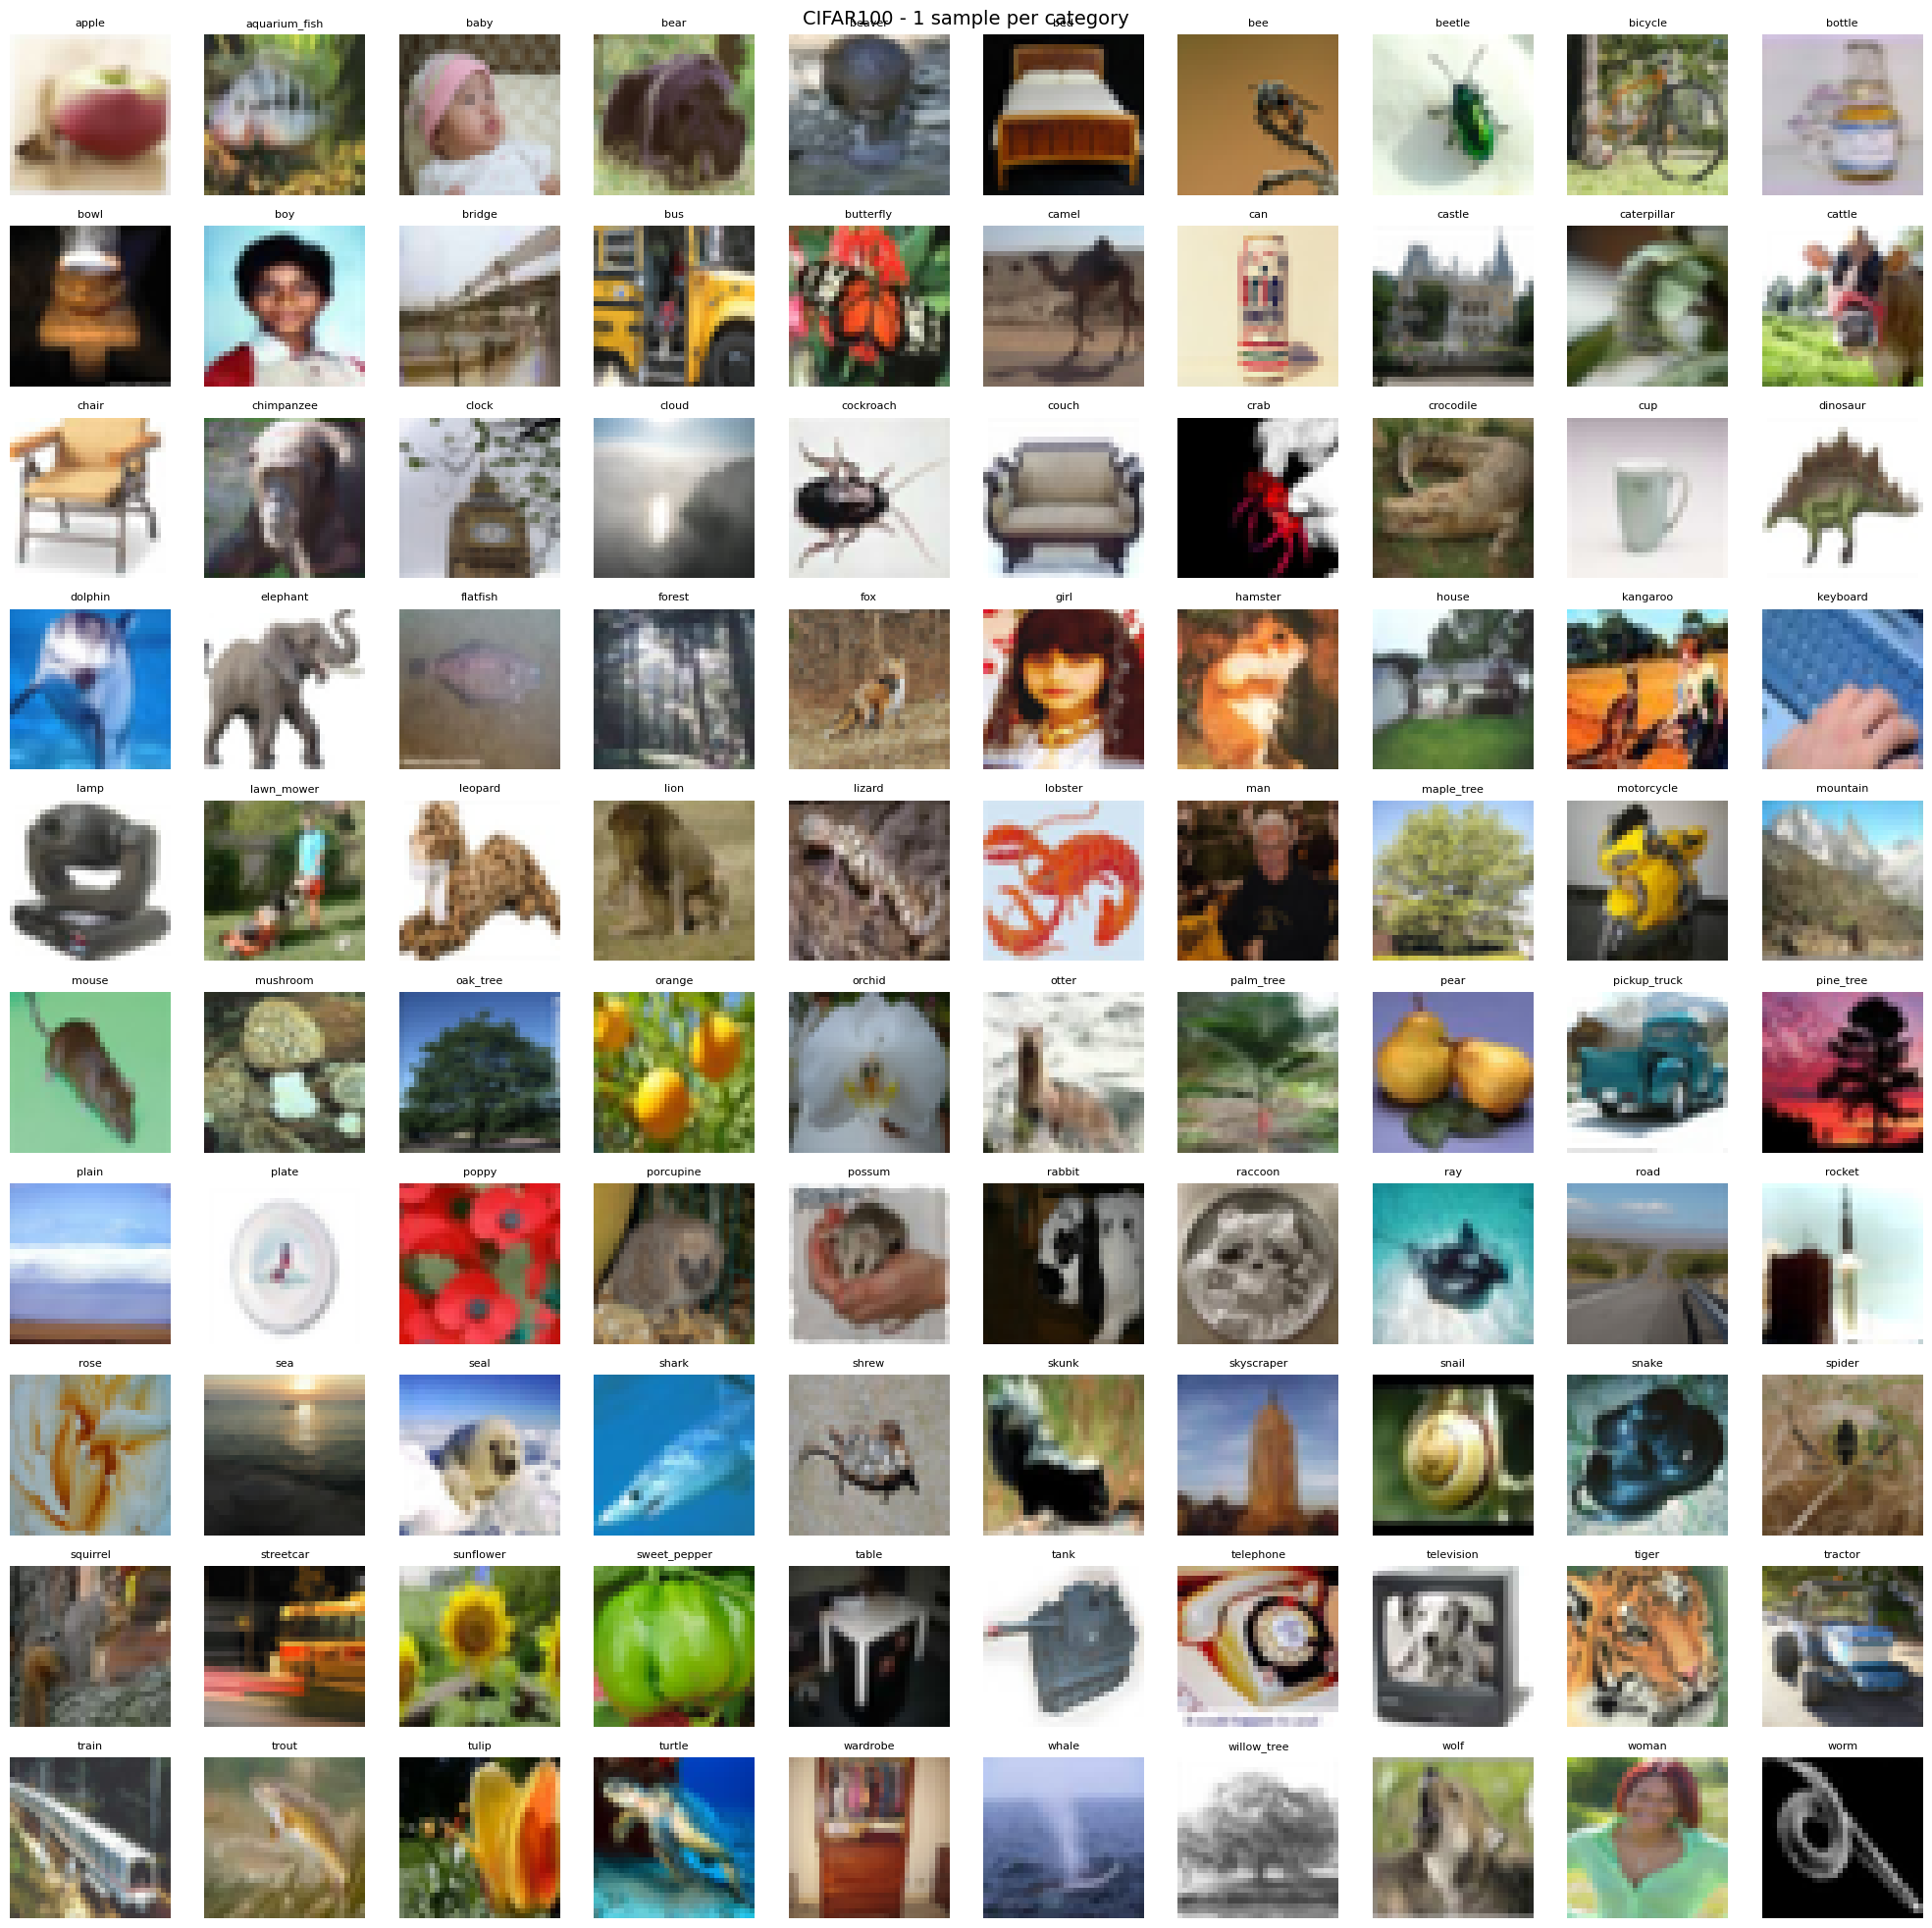

MNIST 카테고리 개수: 10


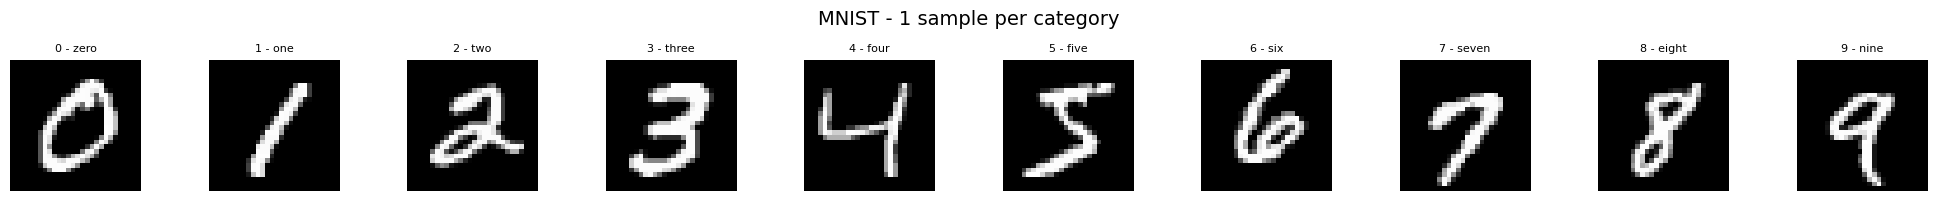

In [ ]:
# --------------------------------------------------
# 데이터셋 정보 출력
# --------------------------------------------------
print_dataset_info("CIFAR100", cifar_train, cifar_test)
print_dataset_info("MNIST", mnist_train, mnist_test)

# --------------------------------------------------
# 각 카테고리별로 1개의 샘플 이미지를 시각화
# --------------------------------------------------
visualize_one_per_category(cifar_train, dataset_name="CIFAR100", cmap=None)
visualize_one_per_category(mnist_train, dataset_name="MNIST", cmap='gray')


두 방법의 최대 차이 (Max Difference): 0.0
두 방법의 평균 차이 (Mean Difference): 0.0


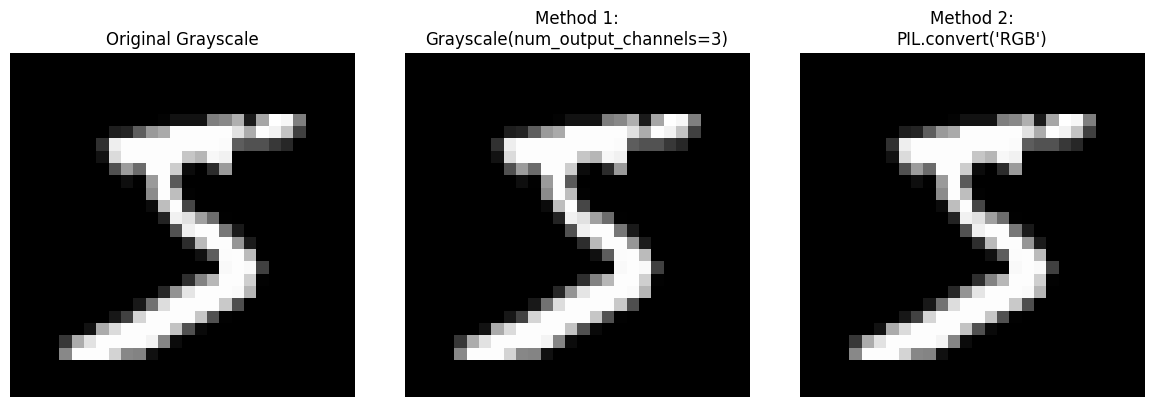

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# MNIST 데이터셋에서 첫 번째 이미지 로드 (그레이스케일)
mnist = datasets.MNIST(root='./data', train=True, download=True)
gray_img_array = mnist.data[0].numpy()  # shape: [28, 28]
gray_img_pil = Image.fromarray(gray_img_array, mode='L')  # PIL 이미지, 모드 'L' (그레이스케일)

# 3채널 데이터로 변환
# 방법 1: transforms.Grayscale(num_output_channels=3) 사용
transform_to3 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
img_method1 = transform_to3(gray_img_pil)  # 텐서 shape: [3, 28, 28]

# 방법 2: PIL의 convert("RGB") 사용 후 ToTensor()
img_method2 = transforms.ToTensor()(gray_img_pil.convert("RGB"))  # 텐서 shape: [3, 28, 28]

# 두 결과의 차이 계산
diff = torch.abs(img_method1 - img_method2)
max_diff = diff.max().item()
mean_diff = diff.mean().item()

print("두 방법의 최대 차이 (Max Difference):", max_diff)
print("두 방법의 평균 차이 (Mean Difference):", mean_diff)

# 시각화 (세 이미지: 원본, 방법1, 방법2)
def imshow_tensor(img_tensor, title=None):
    np_img = img_tensor.numpy().transpose(1, 2, 0)
    plt.imshow(np_img)
    if title:
        plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gray_img_pil, cmap='gray')
plt.title("Original Grayscale")
plt.axis('off')

plt.subplot(1, 3, 2)
imshow_tensor(img_method1, title="Method 1:\nGrayscale(num_output_channels=3)")

plt.subplot(1, 3, 3)
imshow_tensor(img_method2, title="Method 2:\nPIL.convert('RGB')")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm  # 진행 상황을 표시하기 위한 라이브러리
import os

# device 설정 (GPU가 있다면 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 device:", device)

# --------------------------------------------------
# 모델 정의: 간단한 CNN (CIFAR-100 입력에 맞춤)
# --------------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 3 -> 32 채널
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32 -> 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 32 -> 64 채널
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16 -> 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 64 -> 128 채널
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 8x8 -> 4x4
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 100)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

# --------------------------------------------------
# 학습/검증 함수 정의
# --------------------------------------------------
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, leave=False, desc="Train"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0) # 배치당 평균 손실 x 배치 사이즈 --> 배치 내 모든 샘플의 손실 총합
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, leave=False, desc="Val"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# --------------------------------------------------
# 1. CIFAR-100 사전학습 (From Scratch)
# --------------------------------------------------
print("==== CIFAR-100 사전학습 (From Scratch) ====")
# CIFAR-100 전처리 (정규화 값은 공개 문헌 기준)
transform_cifar = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761])
])

# CIFAR-100 데이터셋 다운로드 및 학습/검증 분할 (예: 90% 학습, 10% 검증)
cifar_full = torchvision.datasets.CIFAR100(root='./data', train=True, transform=transform_cifar, download=True)

train_size = int(0.9 * len(cifar_full))
val_size = len(cifar_full) - train_size

cifar_train, cifar_val = random_split(cifar_full, [train_size, val_size])
cifar_train_loader = DataLoader(cifar_train, batch_size=128, shuffle=True, num_workers=2)
cifar_val_loader = DataLoader(cifar_val, batch_size=128, shuffle=False, num_workers=2)

# 모델 초기화, 손실함수, 옵티마이저 정의
model_cifar = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_cifar = optim.Adam(model_cifar.parameters(), lr=0.001)

# CIFAR-100 학습 (예시로 5 에폭 진행)
num_epochs = 5
for epoch in range(num_epochs):
    print(f"\n[Epoch {epoch+1}/{num_epochs}]")
    train_loss, train_acc = train_epoch(model_cifar, cifar_train_loader, criterion, optimizer_cifar)
    val_loss, val_acc = validate_epoch(model_cifar, cifar_val_loader, criterion)
    print(f"Train Loss: {train_loss:.4f} / Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} / Acc: {val_acc:.4f}")

# 학습된 CIFAR-100 모델 저장 (feature extractor 활용을 위해)
os.makedirs('./models', exist_ok=True)
torch.save(model_cifar.state_dict(), './models/model_cifar100.pth')


사용 device: cpu
==== CIFAR-100 사전학습 (From Scratch) ====

[Epoch 1/5]


Train Loss: 4.0361 / Acc: 0.0788
Val   Loss: 3.4696 / Acc: 0.1670

[Epoch 2/5]


Train Loss: 3.5195 / Acc: 0.1460
Val   Loss: 3.0417 / Acc: 0.2376

[Epoch 3/5]


Train Loss: 3.2794 / Acc: 0.1840
Val   Loss: 2.9375 / Acc: 0.2658

[Epoch 4/5]


Train Loss: 3.1422 / Acc: 0.2057
Val   Loss: 2.8206 / Acc: 0.2848

[Epoch 5/5]


Train Loss: 3.0414 / Acc: 0.2261
Val   Loss: 2.6655 / Acc: 0.3112


In [ ]:
# model_cifar.classifier[3] = nn.Linear()

Linear(in_features=256, out_features=100, bias=True)

In [ ]:
model_cifar.features

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
model_cifar.features[11]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [ ]:
model_cifar.classifier[3]

Linear(in_features=256, out_features=100, bias=True)

In [ ]:
# --------------------------------------------------
# MNIST 데이터 전처리 (공통)
# --------------------------------------------------
transform_mnist = transforms.Compose([
    transforms.Resize(32),  # CIFAR-100 모델 입력 크기에 맞춤
    transforms.Grayscale(num_output_channels=3),  # 3채널로 변환
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])
mnist_full = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_mnist, download=True)

mnist_train_size = int(0.9 * len(mnist_full))
mnist_val_size = len(mnist_full) - mnist_train_size

mnist_train, mnist_val = random_split(mnist_full, [mnist_train_size, mnist_val_size])
mnist_train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=2)
mnist_val_loader = DataLoader(mnist_val, batch_size=128, shuffle=False, num_workers=2)


In [ ]:
# --------------------------------------------------
# 1. MNIST Full Fine-tuning (전체 레이어 업데이트)
# --------------------------------------------------
print("\n==== MNIST Full Fine-tuning (전체 레이어 업데이트) ====")
# MNIST 모델 생성 (우선 CIFAR-100 구조로 생성)
model_mnist_ft = SimpleCNN().to(device)

# CIFAR-100 사전학습된 feature extractor 로드 (features 부분만 복사)
model_cifar_dict = torch.load('./models/model_cifar100.pth', map_location=device)

model_dict = model_mnist_ft.state_dict()

pretrained_dict = {k: v for k, v in model_cifar_dict.items() if k.startswith("features")}

model_dict.update(pretrained_dict)
model_mnist_ft.load_state_dict(model_dict)


# classifier 교체: 마지막 레이어를 MNIST 분류(10 클래스)에 맞게 변경
model_mnist_ft.classifier[3] = nn.Linear(256, 10).to(device)
print("MNIST Full Fine-tuning 모델:", model_mnist_ft)


# 전체 파라미터 업데이트하므로 feature extractor 고정하지 않음.
# 전체 모델에 대해 작은 학습률 적용 (예: 1e-4)
optimizer_mnist_ft = optim.Adam(model_mnist_ft.parameters(), lr=1e-4)

# metric 저장을 위한 리스트 초기화 (Full Fine-tuning)
ft_train_losses, ft_train_accs = [], []
ft_val_losses, ft_val_accs = [], []

num_epochs_mnist = 3
for epoch in range(num_epochs_mnist):
    print(f"\n[MNIST Full Fine-tuning Epoch {epoch+1}/{num_epochs_mnist}]")
    train_loss, train_acc = train_epoch(model_mnist_ft, mnist_train_loader, criterion, optimizer_mnist_ft)
    val_loss, val_acc = validate_epoch(model_mnist_ft, mnist_val_loader, criterion)
    print(f"Train Loss: {train_loss:.4f} / Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} / Acc: {val_acc:.4f}")
    ft_train_losses.append(train_loss)
    ft_train_accs.append(train_acc)
    ft_val_losses.append(val_loss)
    ft_val_accs.append(val_acc)



==== MNIST Full Fine-tuning (전체 레이어 업데이트) ====
MNIST Full Fine-tuning 모델: SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True

Train Loss: 0.3358 / Acc: 0.9178
Val   Loss: 0.0730 / Acc: 0.9787

[MNIST Full Fine-tuning Epoch 2/3]


Train Loss: 0.0762 / Acc: 0.9788
Val   Loss: 0.0453 / Acc: 0.9862

[MNIST Full Fine-tuning Epoch 3/3]


Train Loss: 0.0544 / Acc: 0.9839
Val   Loss: 0.0369 / Acc: 0.9888


In [ ]:
# --------------------------------------------------
# 2. MNIST Feature Extraction (classifier만 업데이트)
# --------------------------------------------------
print("\n==== MNIST Feature Extraction (Classifier 학습) ====")

# MNIST 모델 생성 (초기 CIFAR-100 구조로 생성)
model_mnist_fe = SimpleCNN().to(device)
model_dict_fe = model_mnist_fe.state_dict()
pretrained_dict_fe = {k: v for k, v in model_cifar_dict.items() if k.startswith("features")}
model_dict_fe.update(pretrained_dict_fe)
model_mnist_fe.load_state_dict(model_dict_fe)

# feature extractor 고정
for param in model_mnist_fe.features.parameters():
    param.requires_grad = False

# feature extractor 고정 확인
for name, param in model_mnist_fe.named_parameters():
    print(f"{name}: ", param.requires_grad)
print("\n")

# classifier 교체: 새 분류기로 재정의 (예: 중간층 축소)
model_mnist_fe.classifier = nn.Sequential(
    nn.Linear(128 * 4 * 4, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

print("MNIST Feature Extraction 모델:", model_mnist_fe)

# classifier만 업데이트
optimizer_mnist_fe = optim.Adam(model_mnist_fe.classifier.parameters(), lr=1e-3)

# metric 저장을 위한 리스트 초기화 (Feature Extraction)
fe_train_losses, fe_train_accs = [], []
fe_val_losses, fe_val_accs = [], []
for epoch in range(num_epochs_mnist):
    print(f"\n[MNIST Feature Extraction Epoch {epoch+1}/{num_epochs_mnist}]")
    train_loss, train_acc = train_epoch(model_mnist_fe, mnist_train_loader, criterion, optimizer_mnist_fe)
    val_loss, val_acc = validate_epoch(model_mnist_fe, mnist_val_loader, criterion)
    print(f"Train Loss: {train_loss:.4f} / Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} / Acc: {val_acc:.4f}")
    fe_train_losses.append(train_loss)
    fe_train_accs.append(train_acc)
    fe_val_losses.append(val_loss)
    fe_val_accs.append(val_acc)



==== MNIST Feature Extraction (Classifier 학습) ====
features.0.weight:  False
features.0.bias:  False
features.1.weight:  False
features.1.bias:  False
features.4.weight:  False
features.4.bias:  False
features.5.weight:  False
features.5.bias:  False
features.8.weight:  False
features.8.bias:  False
features.9.weight:  False
features.9.bias:  False
classifier.0.weight:  True
classifier.0.bias:  True
classifier.3.weight:  True
classifier.3.bias:  True
MNIST Feature Extraction 모델: SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, s

Train Loss: 0.1389 / Acc: 0.9598
Val   Loss: 0.0663 / Acc: 0.9777

[MNIST Feature Extraction Epoch 2/3]


Train Loss: 0.0552 / Acc: 0.9829
Val   Loss: 0.0639 / Acc: 0.9790

[MNIST Feature Extraction Epoch 3/3]


Train Loss: 0.0432 / Acc: 0.9865
Val   Loss: 0.0634 / Acc: 0.9792


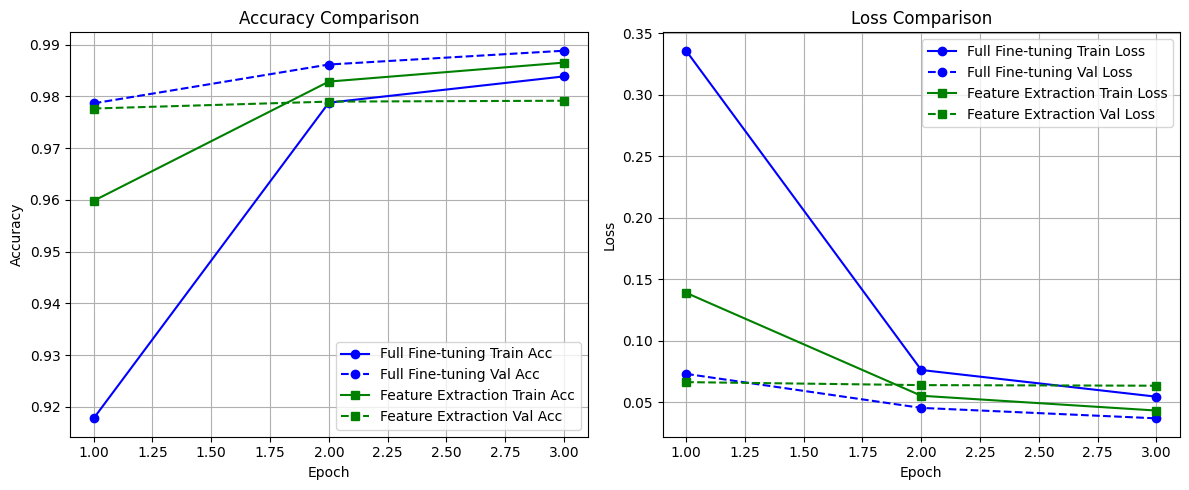

In [ ]:
# --------------------------------------------------
# 성능 비교 Plot 그리기 (Accuracy 및 Loss)
# --------------------------------------------------
epochs = range(1, num_epochs_mnist + 1)

plt.figure(figsize=(12, 5))

# Accuracy 비교
plt.subplot(1, 2, 1)
plt.plot(epochs, ft_train_accs, 'o-', c='b', label='Full Fine-tuning Train Acc')
plt.plot(epochs, ft_val_accs, 'o--',c='b', label='Full Fine-tuning Val Acc')
plt.plot(epochs, fe_train_accs, 's-',c='g', label='Feature Extraction Train Acc')
plt.plot(epochs, fe_val_accs, 's--', c='g',label='Feature Extraction Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.grid(True)

# Loss 비교
plt.subplot(1, 2, 2)
plt.plot(epochs, ft_train_losses, 'o-', c='b', label='Full Fine-tuning Train Loss')
plt.plot(epochs, ft_val_losses, 'o--', c='b', label='Full Fine-tuning Val Loss')
plt.plot(epochs, fe_train_losses, 's-',c='g', label='Feature Extraction Train Loss')
plt.plot(epochs, fe_val_losses, 's--', c='g', label='Feature Extraction Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 사전훈련된 모델 활용

'''
1. 사전훈련된 모델 가져오기

2. 분류기만 수정 // 일부 레이어 (추가 / 수정)
    - 모델 레이어 / 블록 인덱싱 = 새로 할당
    # model_mnist_fe.classifier = nn.Sequential([])

3. freeze : 동결
    for param in model_mnist_fe.features.parameters():
        param.requires_grad = False

4. Training
'''


In [ ]:
for name, param in model_mnist_fe.named_parameters():
    print(f"{name}: ", param.requires_grad)

features.0.weight:  False
features.0.bias:  False
features.1.weight:  False
features.1.bias:  False
features.4.weight:  False
features.4.bias:  False
features.5.weight:  False
features.5.bias:  False
features.8.weight:  False
features.8.bias:  False
features.9.weight:  False
features.9.bias:  False
classifier.0.weight:  True
classifier.0.bias:  True
classifier.2.weight:  True
classifier.2.bias:  True
